In [1]:
import sampling
import random
import torch
from models import graphClassifier
from torch_geometric.loader import DataLoader
import pandas as pd
from torch_geometric.datasets import TUDataset
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load some example dataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
# covnert the dataset to networkx 
dataset_nx = np.array([torch_geometric.utils.to_networkx(data, to_undirected = True, node_attrs= ["x"]) for data in dataset])


print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/tmp/ipykernel_16434/3658682324.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_nx = np.array([torch_geometric.utils.to_networkx(data, to_undirected = True, node_attrs= ["x"]) for data in dataset])


In [3]:
train_mask = np.random.choice(np.arange(0, len(dataset)), size= int(len(dataset)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(dataset)), train_mask)


sampler = sampling.SubgraphSampler("rnn")

subgraph_node_num = 10

# create random samples 
all_graphs_torch  = []
all_graphs_nx  = []

for i, data in enumerate(dataset_nx[train_mask]):
    rs_0_nx, rs_0_torch = sampler.randomGeomSubgraphs(data, label = dataset[i].y.detach().numpy()[0], starts = 1, node_sample_size = subgraph_node_num)
    all_graphs_torch += rs_0_torch
    all_graphs_nx += rs_0_nx


random.shuffle(all_graphs_torch)

# split into training and test set
breaker = int(len(all_graphs_torch)*0.8)
train_dataset = all_graphs_torch[:breaker]
test_dataset = all_graphs_torch[breaker:]

Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 915.39it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 1461.94it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 1514.74it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 621.65it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 978.61it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 1837.99it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 1573.85it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 1389.76it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 1/1 [00:00<00:00, 1346.05it/s]
Creating subgraphs using random node neighbor sel

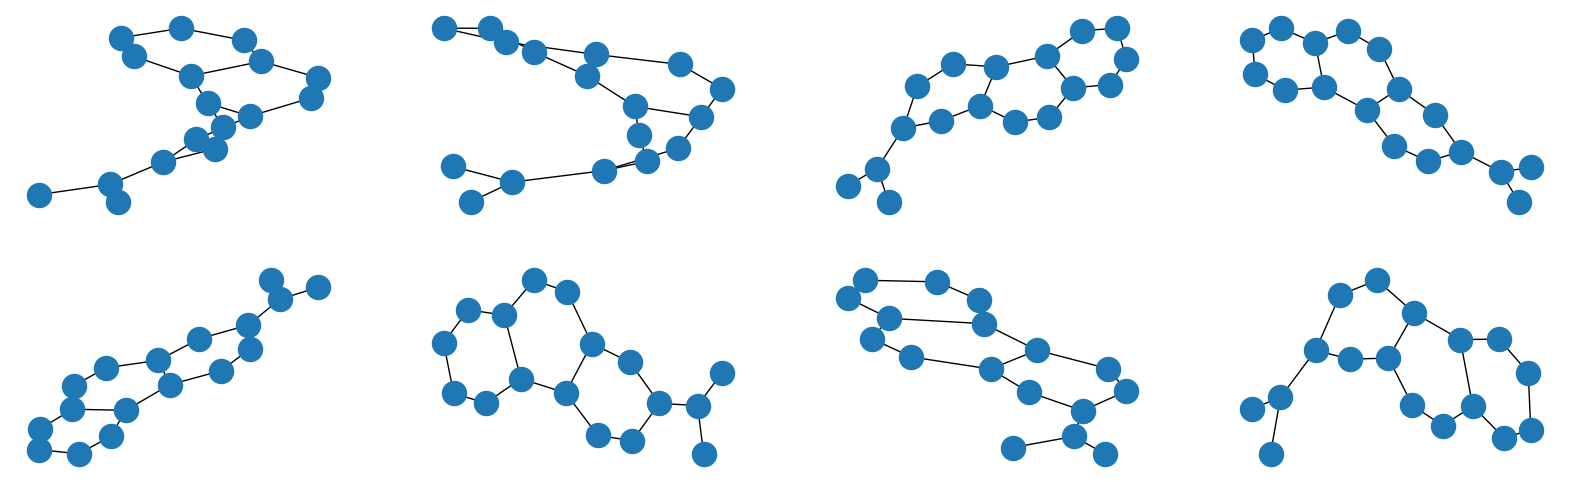

In [4]:
fig, ax = plt.subplots(2,4, figsize = (20,6))
for i in range(2*4):
    row = i //4
    col = i %4
    nx.draw(dataset_nx[0],ax = ax[row,col])
    #nx.draw(all_graphs_nx[0],ax = ax[0,1])

In [8]:
# selection of the features to use
num_features = dataset.num_features
num_classes = dataset.num_classes


# try different aggregation modes:
# other aggragtion schemas not supported for batches
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool


# create the model
model = graphClassifier.GCN_GC(in_channels= num_features, hidden_channels = 64,out_channels= num_classes, num_layers=1, dropout = 0.2, aggregation_mode= global_add_pool)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# create brach data loaders for training and test set
train_loader = DataLoader(dataset[train_mask], batch_size = 8, shuffle=True)
test_loader = DataLoader(dataset[test_mask], batch_size = 8, shuffle=False)


def train_GC():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch, training = True)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.


def test_GC(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch, training = False)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


epochs = 500

for epoch in range(1, epochs+1):
    train_GC()
    train_acc = test_GC(train_loader)
    test_acc = test_GC(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



Epoch: 001, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 002, Train Acc: 0.7533, Test Acc: 0.6579
Epoch: 003, Train Acc: 0.7467, Test Acc: 0.5789
Epoch: 004, Train Acc: 0.7333, Test Acc: 0.5789
Epoch: 005, Train Acc: 0.7733, Test Acc: 0.6579
Epoch: 006, Train Acc: 0.7467, Test Acc: 0.5789
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.5526
Epoch: 008, Train Acc: 0.7467, Test Acc: 0.5526
Epoch: 009, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 010, Train Acc: 0.7533, Test Acc: 0.5789
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.6579
Epoch: 012, Train Acc: 0.7467, Test Acc: 0.5526
Epoch: 013, Train Acc: 0.7467, Test Acc: 0.5789
Epoch: 014, Train Acc: 0.7467, Test Acc: 0.5526
Epoch: 015, Train Acc: 0.7600, Test Acc: 0.6053
Epoch: 016, Train Acc: 0.7933, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7467, Test Acc: 0.6842
Epoch: 018, Train Acc: 0.7600, Test Acc: 0.6053
Epoch: 019, Train Acc: 0.8467, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.8133, Test Acc: 0.7895
Epoch: 021, Train Acc: 0.7600, Test Acc:

In [6]:
# evaluate on the input dataset
def test_final(dataset):
     model.eval()

     correct = 0
     for data in dataset:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(dataset)  # Derive ratio of correct predictions.


test_acc = test_final(dataset[test_mask])
print(test_acc)

0.6052631578947368
